In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt
import anndata
from SpaceFlow import SpaceFlow

import warnings

warnings.filterwarnings('ignore')

In [2]:
BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb')
output_path = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/Mouse_Olfactory_Bulb/SpaceFlow')

In [4]:
data_root = BASE_PATH
dir_output = output_path
dir_output.mkdir(parents=True, exist_ok=True)

n_clusters = 7

In [5]:
counts_file = os.path.join(data_root, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_root, 'position.tsv')

counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')

counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

adata = sc.read_h5ad(os.path.join(data_root, 'raw.h5ad'))
adata.var_names_make_unique()

coords = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

used_barcode = pd.read_csv(os.path.join(data_root, 'used_barcodes.txt'), sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
adata

View of AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'x', 'y'
    obsm: 'spatial'

(6005.190789473684, 12428.6600877193, 9986.774763741741, 15062.302776957435)

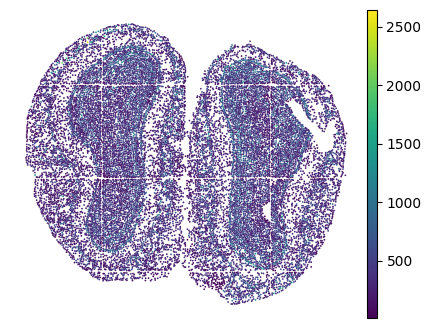

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

plt.rcParams["figure.figsize"] = (5,4)
sc.pl.embedding(adata, basis="spatial", color="n_genes_by_counts", show=False)
plt.title("")
plt.axis('off')

In [7]:
sc.pp.filter_genes(adata, min_cells=3)

sf = SpaceFlow.SpaceFlow(adata=adata)
sf.preprocessing_data(n_top_genes=3000)

sf.train(
    spatial_regularization_strength=0.1,
    z_dim=50,
    lr=1e-3,
    epochs=1000,
    max_patience=50,
    min_stop=100,
    random_seed=42,
    gpu=7,
    regularization_acceleration=True,
    edge_subset_sz=1000000,
    embedding_save_filepath=os.path.join(dir_output, "low_dim_data.csv"),
)

adata.obsm['SpaceFlow'] = sf.embedding

embedding = anndata.AnnData(sf.embedding)
sc.pp.neighbors(embedding, n_neighbors=50, use_rep='X')

for res in sorted(list(np.arange(0.2, 2.5, 0.1)), reverse=True):
    sc.tl.leiden(embedding, resolution=res)
    
    if len(pd.DataFrame(embedding.obs['leiden']).leiden.unique()) == n_clusters:
        print(f"Resolution: {res}")
        break

sf.segmentation(domain_label_save_filepath=os.path.join(dir_output, "domain_labels.csv"),
                n_neighbors=50,
                resolution=res)

# sc.pp.neighbors(adata, n_neighbors=50)
# sc.tl.umap(adata)

pred = pd.read_csv(os.path.join(dir_output, "domain_labels.csv"), header=None)
adata.obs['pred'] = pred.values
adata.obs["pred"] = adata.obs["pred"].astype("category")  # Convert to categorical


Epoch 2/1000, Loss: 1.4481738805770874
Epoch 12/1000, Loss: 1.4149287939071655
Epoch 22/1000, Loss: 1.3088160753250122
Epoch 32/1000, Loss: 1.022617220878601
Epoch 42/1000, Loss: 0.7643635869026184
Epoch 52/1000, Loss: 0.5699571371078491
Epoch 62/1000, Loss: 0.4318378269672394
Epoch 72/1000, Loss: 0.35528650879859924
Epoch 82/1000, Loss: 0.2873847186565399
Epoch 92/1000, Loss: 0.24224309623241425
Epoch 102/1000, Loss: 0.22262105345726013
Epoch 112/1000, Loss: 0.2125672996044159
Epoch 122/1000, Loss: 0.18884681165218353
Epoch 132/1000, Loss: 0.16706602275371552
Epoch 142/1000, Loss: 0.15880253911018372
Epoch 152/1000, Loss: 0.14706602692604065
Epoch 162/1000, Loss: 0.14264091849327087
Epoch 172/1000, Loss: 0.15175655484199524
Epoch 182/1000, Loss: 0.12547224760055542
Epoch 192/1000, Loss: 0.127963125705719
Epoch 202/1000, Loss: 0.11992141604423523
Epoch 212/1000, Loss: 0.11787886917591095
Epoch 222/1000, Loss: 0.11008256673812866
Epoch 232/1000, Loss: 0.10059347748756409
Epoch 242/1000,

In [9]:
adata

AnnData object with n_obs × n_vars = 19109 × 3000
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pred'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca', 'SpaceFlow'
    varm: 'PCs'

In [14]:
adata.obs['pred_shift'] = (adata.obs['pred'].astype(int) + 1).astype("category")

In [15]:
adata

AnnData object with n_obs × n_vars = 19109 × 3000
    obs: 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pred', 'pred_shift'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'pred_colors'
    obsm: 'spatial', 'X_pca', 'SpaceFlow'
    varm: 'PCs'

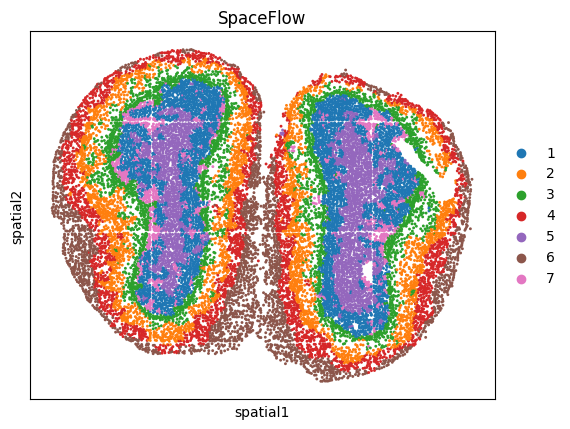

In [16]:
# plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color="pred_shift", show=False, title='SpaceFlow', ax=ax, spot_size=40)
ax.invert_yaxis()
# plt.axis('off')
plt.savefig(os.path.join(output_path, 'clustering.pdf'), dpi=300, bbox_inches='tight')

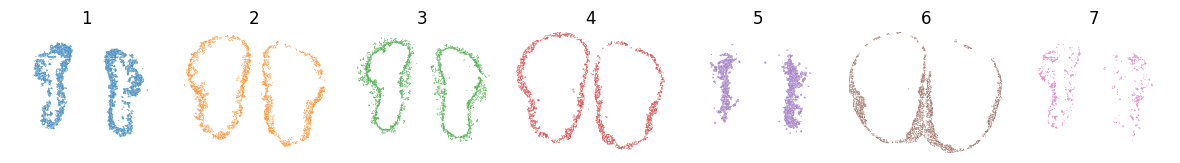

In [18]:
fig, axes = plt.subplots(1,n_clusters,figsize=(1.7*n_clusters, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_clusters):
    sub = adata[adata.obs['pred_shift'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='pred_shift', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)


xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(output_path, f'each_cluster.pdf'), dpi=300, bbox_inches='tight')

In [19]:
cell_metadata = adata.obs
cell_metadata

,x,y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,pred,pred_shift
Spot_1,12555.007833,6307.537859,428,6.061457,490.842621,6.198159,21.799251,33.176138,53.549266,100.000006,5,6
Spot_10,12806.715054,6311.983871,209,5.347108,240.722229,5.487789,33.948764,54.719595,96.261251,100.000000,5,6
Spot_100,12752.469565,6425.617391,153,5.036953,189.000000,5.247024,45.502646,71.957672,100.000000,100.000000,5,6
Spot_1000,12545.601942,6856.786408,177,5.181784,212.833328,5.365197,40.328892,63.821451,99.999993,99.999993,3,4
Spot_10000,12993.429134,9153.204724,332,5.808142,386.515137,5.959755,27.040377,39.976481,65.848689,100.000000,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
Spot_9994,14127.819588,9148.005155,275,5.620401,325.076904,5.787133,30.785614,46.166589,76.928541,100.000000,5,6
Spot_9995,12933.872611,9147.484076,208,5.342334,261.500000,5.570251,39.579350,58.699809,96.940727,100.000000,5,6
Spot_9996,13328.963303,9155.389908,334,5.814131,388.083313,5.963793,26.733950,39.703677,65.471340,100.000008,5,6
Spot_9998,12637.854167,9150.281250,122,4.812184,136.833344,4.926045,47.381240,83.922046,100.000000,100.000000,5,6


In [20]:
cell_metadata.to_csv(os.path.join(output_path, 'cell_metadata.csv'))